In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.utils.data
from torch.autograd import Variable

# Load the data

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


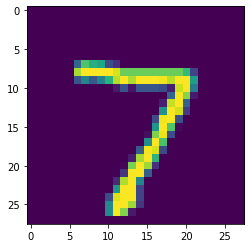

displaying a 7


In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)


    plt.imshow(X[0][0].numpy())
    plt.show()
    print(f'displaying a {y[0]}')
    break

# Define the various optimizer uses.

 Separately train using RMSProp, ADAM, and Nesterov optimizers

# RMSProp

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=8)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=8)
        self.fc1 = nn.Linear(7*7*12, 30)
        self.fc2 = nn.Linear(30, 10)

        torch.nn.init.xavier_uniform(self.conv1.weight)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1,7*7*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = BaselineCNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters())

Using cuda device
BaselineCNN(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=588, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


Training loop is based on https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [8]:
train_losses = []
test_losses = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_losses.append(loss)

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    test_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.368649  [    0/60000]
loss: 0.327204  [ 6400/60000]
loss: 0.155127  [12800/60000]
loss: 0.354433  [19200/60000]
loss: 0.060395  [25600/60000]
loss: 0.151675  [32000/60000]
loss: 0.239304  [38400/60000]
loss: 0.117325  [44800/60000]
loss: 0.186859  [51200/60000]
loss: 0.080646  [57600/60000]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.002040 

Epoch 2
-------------------------------
loss: 0.045778  [    0/60000]
loss: 0.098100  [ 6400/60000]
loss: 0.163641  [12800/60000]
loss: 0.182332  [19200/60000]
loss: 0.008499  [25600/60000]
loss: 0.051678  [32000/60000]
loss: 0.197871  [38400/60000]
loss: 0.108846  [44800/60000]
loss: 0.103049  [51200/60000]
loss: 0.327690  [57600/60000]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.001703 

Epoch 3
-------------------------------
loss: 0.019925  [    0/60000]
loss: 0.076160  [ 6400/60000]
loss: 0.129600  [12800/60000]
loss: 0.206690  [19200/60000]
loss: 0.105909  [25600/60000]
loss: 0.132145  [32000/600

Generate learning curves for the validation and training set. Discuss whether this base-
line system overfits, underfits or reasonably fits the validation data. Test this baseline system with
the testing data and report the accuracy and show a confusion matrix

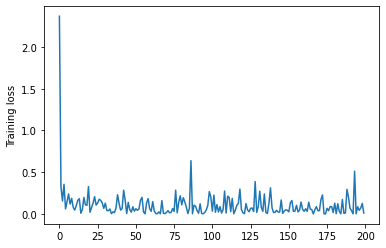

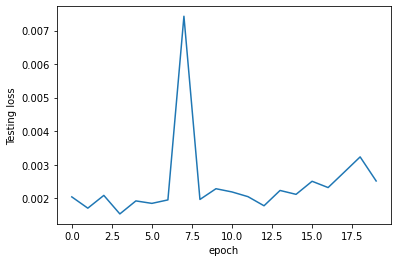

In [9]:
plt.plot(train_losses)
plt.ylabel('Training loss')
plt.show()

plt.plot(test_losses)
plt.ylabel('Testing loss')
plt.xlabel('epoch')
plt.show()

There's a strange spike in testing loss around epoch 6, but otherwise it converges around 98.1% accuracy which is pretty good. It only took about 2 epochs to do this as well!

# ADAM

Using cuda device
BaselineCNN(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=588, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)
Epoch 1
-------------------------------
loss: 2.322557  [    0/60000]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


loss: 0.232277  [ 6400/60000]
loss: 0.232252  [12800/60000]
loss: 0.216996  [19200/60000]
loss: 0.136683  [25600/60000]
loss: 0.143773  [32000/60000]
loss: 0.159405  [38400/60000]
loss: 0.261035  [44800/60000]
loss: 0.321862  [51200/60000]
loss: 0.188908  [57600/60000]
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.001379 

Epoch 2
-------------------------------
loss: 0.056094  [    0/60000]
loss: 0.078896  [ 6400/60000]
loss: 0.079374  [12800/60000]
loss: 0.157512  [19200/60000]
loss: 0.034417  [25600/60000]
loss: 0.104303  [32000/60000]
loss: 0.091373  [38400/60000]
loss: 0.098766  [44800/60000]
loss: 0.193015  [51200/60000]
loss: 0.155488  [57600/60000]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.000910 

Epoch 3
-------------------------------
loss: 0.023931  [    0/60000]
loss: 0.111307  [ 6400/60000]
loss: 0.047476  [12800/60000]
loss: 0.150202  [19200/60000]
loss: 0.014320  [25600/60000]
loss: 0.082149  [32000/60000]
loss: 0.087187  [38400/60000]
loss: 0.069309  [44800/60000]
loss: 

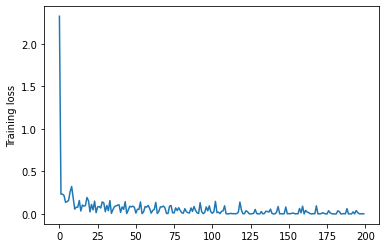

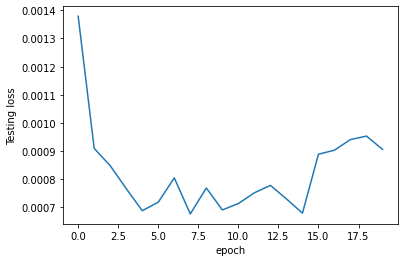

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=8)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=8)
        self.fc1 = nn.Linear(7*7*12, 30)
        self.fc2 = nn.Linear(30, 10)

        torch.nn.init.xavier_uniform(self.conv1.weight)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1,7*7*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = BaselineCNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses = []
test_losses = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_losses.append(loss)

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    test_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

plt.plot(train_losses)
plt.ylabel('Training loss')
plt.show()

plt.plot(test_losses)
plt.ylabel('Testing loss')
plt.xlabel('epoch')
plt.show()

Not much to say, it reaches good accuracy after a couple epochs then bounces up and down a little, just like the others.

# Nesterov

Using cuda device
BaselineCNN(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=588, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)
Epoch 1
-------------------------------
loss: 2.344726  [    0/60000]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


loss: 0.230174  [ 6400/60000]
loss: 0.134549  [12800/60000]
loss: 0.261744  [19200/60000]
loss: 0.086878  [25600/60000]
loss: 0.072222  [32000/60000]
loss: 0.119437  [38400/60000]
loss: 0.080059  [44800/60000]
loss: 0.070838  [51200/60000]
loss: 0.094823  [57600/60000]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.002275 

Epoch 2
-------------------------------
loss: 0.066985  [    0/60000]
loss: 0.093228  [ 6400/60000]
loss: 0.110450  [12800/60000]
loss: 0.023695  [19200/60000]
loss: 0.036454  [25600/60000]
loss: 0.092635  [32000/60000]
loss: 0.077842  [38400/60000]
loss: 0.112146  [44800/60000]
loss: 0.105887  [51200/60000]
loss: 0.022459  [57600/60000]
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.001521 

Epoch 3
-------------------------------
loss: 0.038716  [    0/60000]
loss: 0.030222  [ 6400/60000]
loss: 0.025085  [12800/60000]
loss: 0.009375  [19200/60000]
loss: 0.075347  [25600/60000]
loss: 0.035564  [32000/60000]
loss: 0.076115  [38400/60000]
loss: 0.037778  [44800/60000]
loss: 

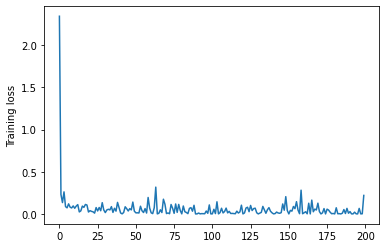

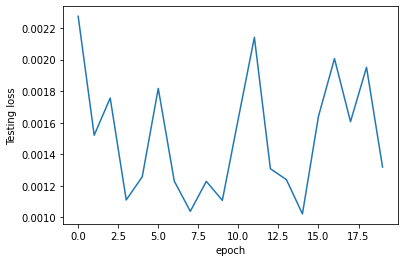

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=8)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=8)
        self.fc1 = nn.Linear(7*7*12, 30)
        self.fc2 = nn.Linear(30, 10)

        torch.nn.init.xavier_uniform(self.conv1.weight)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1,7*7*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = BaselineCNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, nesterov=True)

train_losses = []
test_losses = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_losses.append(loss)

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    test_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

plt.plot(train_losses)
plt.ylabel('Training loss')
plt.show()

plt.plot(test_losses)
plt.ylabel('Testing loss')
plt.xlabel('epoch')
plt.show()

Not much to say, it reaches good accuracy after a couple epochs then bounces up and down a little, just like the others.